In [65]:
import os
import gc
import sys
import numpy as np
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
# from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import IPython.display as ipd

%matplotlib inline
plt.rcParams['figure.figsize'] = (32.0, 32.0) # set default size of plots


In [66]:
if torch.cuda.is_available():
            print('CUDA available')
            print(torch.cuda.get_device_name(0))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
            
else:
    print('WARNING: CUDA is not available')

CUDA available
NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.9 GB
Cached:    2.7 GB


In [67]:
# Global Vars

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "./Data/genres_original/"
csv_3 = "./Data/features_3_sec.csv"
csv_30 = "./Data/features_30_sec.csv"

audio_paths = [f for f in Path(path).glob('*\*.wav')]

batch_size = 32
num_workers = 0
epochs = 50

validation_split = .2
random_seed= 42

%matplotlib inline
plt.rcParams['figure.figsize'] = (32.0, 32.0) # set default size of plots

print(audio_paths[:10])

[WindowsPath('Data/genres_original/blues/blues.00000.wav'), WindowsPath('Data/genres_original/blues/blues.00001.wav'), WindowsPath('Data/genres_original/blues/blues.00002.wav'), WindowsPath('Data/genres_original/blues/blues.00003.wav'), WindowsPath('Data/genres_original/blues/blues.00004.wav'), WindowsPath('Data/genres_original/blues/blues.00005.wav'), WindowsPath('Data/genres_original/blues/blues.00006.wav'), WindowsPath('Data/genres_original/blues/blues.00007.wav'), WindowsPath('Data/genres_original/blues/blues.00008.wav'), WindowsPath('Data/genres_original/blues/blues.00009.wav')]


In [68]:
# Local Dataset
# data = DataLoader(path, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

# get class mapping
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_dict = find_classes(path)

print(classes, list(class_dict.items())[:10])

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'] [('blues', 0), ('classical', 1), ('country', 2), ('disco', 3), ('hiphop', 4), ('jazz', 5), ('metal', 6), ('pop', 7), ('reggae', 8), ('rock', 9)]


In [69]:
# Dataset
# Data in the Models folder containts 100 audio samples per class
# This function splits audio into 80/20 train and test splits
class GTZAN(Dataset):
        def __init__(self, paths: list, transform=None):
                self.paths = paths
                self.transform = transform
        
        def __len__(self):
                return len(self.paths)

        def __getitem__(self, index):              
                signal, sr = torchaudio.load(self.paths[index])
                if self.transform:
                        signal = self.transform(signal)
                label = self.paths[index].__str__().split('\\')[2]
                return signal, label        

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [torch.tensor(class_dict[label])]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets               

test_paths = []
train_paths = []
for genre in classes:
        # get list of audio files in that genre
        samples = [f for f in Path(path).glob(f'*\{genre}.*.wav')]

        # Split list 80:20
        trainlist = samples[:80] # first 80
        testlist = samples[80:] 
        test_paths.extend(testlist)
        train_paths.extend(trainlist)

transform = torchaudio.transforms.Resample()

train_set = GTZAN(train_paths)
test_set = GTZAN(test_paths)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, collate_fn=collate_fn)


Shape of waveform: torch.Size([1, 661794])


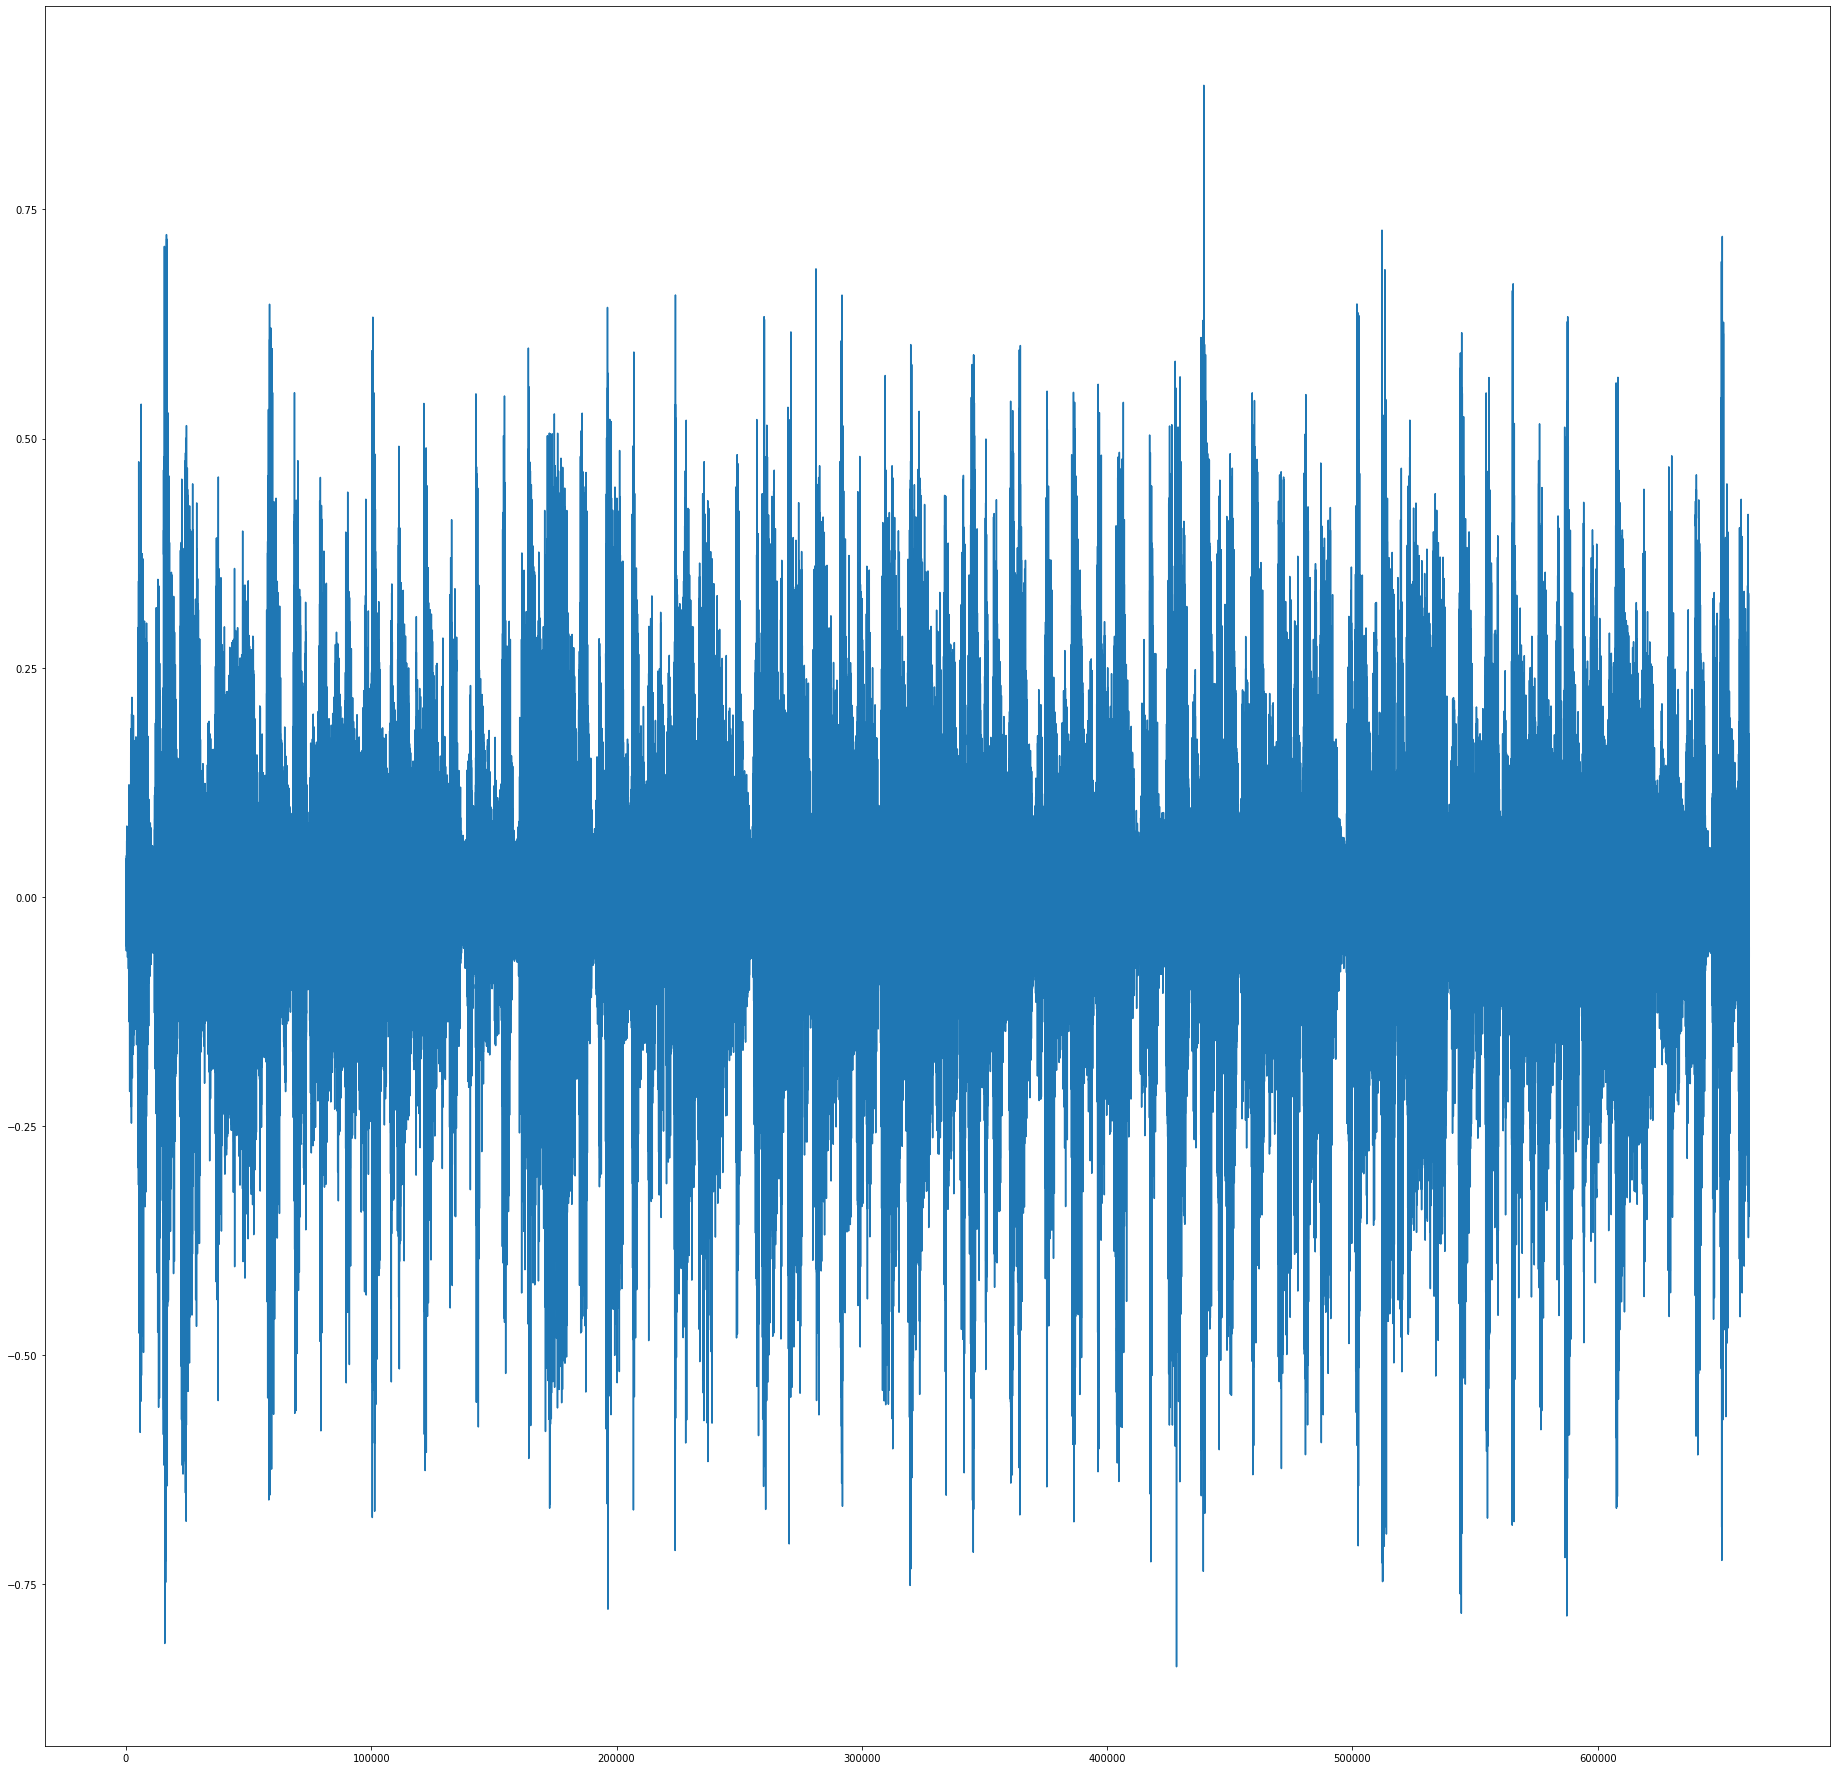

In [70]:
# visualise one audio sample
sample = train_set[0][0]
print("Shape of waveform: {}".format(train_set[0][0].size()))
plt.plot(sample.t().numpy())

In [71]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


input_size = train_set[0][0].shape[0]
model = M5(n_input=input_size, n_output=len(classes))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

In [72]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [73]:
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=epochs) as pbar:
    for epoch in range(1, epochs + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0.09375/50 [00:00<04:27,  5.35s/it]

Train Epoch: 1 [0/800 (0%)]	Loss: 2.314353


  1%|▏         | 0.71875/50 [00:02<02:39,  3.23s/it]

Train Epoch: 1 [640/800 (80%)]	Loss: 1.759312


  2%|▏         | 1.0625/50 [00:03<02:05,  2.56s/it] 


Test Epoch: 1	Accuracy: 44/199 (22%)

Train Epoch: 2 [0/800 (0%)]	Loss: 1.790316


  3%|▎         | 1.71875/50 [00:05<02:37,  3.26s/it]

Train Epoch: 2 [640/800 (80%)]	Loss: 1.583975


  4%|▍         | 2.0625/50 [00:06<02:04,  2.59s/it] 


Test Epoch: 2	Accuracy: 55/199 (28%)

Train Epoch: 3 [0/800 (0%)]	Loss: 1.295556


  5%|▌         | 2.71875/50 [00:08<02:31,  3.21s/it]

Train Epoch: 3 [640/800 (80%)]	Loss: 1.347469


  6%|▌         | 3.0625/50 [00:09<02:03,  2.62s/it] 


Test Epoch: 3	Accuracy: 49/199 (25%)

Train Epoch: 4 [0/800 (0%)]	Loss: 1.242766


  7%|▋         | 3.71875/50 [00:11<02:29,  3.24s/it]

Train Epoch: 4 [640/800 (80%)]	Loss: 1.673024


  8%|▊         | 4.0625/50 [00:12<02:01,  2.64s/it] 


Test Epoch: 4	Accuracy: 68/199 (34%)

Train Epoch: 5 [0/800 (0%)]	Loss: 1.191393


  9%|▉         | 4.71875/50 [00:15<02:31,  3.35s/it]

Train Epoch: 5 [640/800 (80%)]	Loss: 1.208557


 10%|█         | 5.0625/50 [00:16<01:56,  2.60s/it] 


Test Epoch: 5	Accuracy: 69/199 (35%)

Train Epoch: 6 [0/800 (0%)]	Loss: 1.170337


 11%|█▏        | 5.71875/50 [00:18<02:22,  3.22s/it]

Train Epoch: 6 [640/800 (80%)]	Loss: 1.198061


 12%|█▏        | 6.03125/50 [00:19<01:51,  2.54s/it]


Test Epoch: 6	Accuracy: 73/199 (37%)

Train Epoch: 7 [0/800 (0%)]	Loss: 1.183038


 13%|█▎        | 6.71875/50 [00:21<02:20,  3.25s/it]

Train Epoch: 7 [640/800 (80%)]	Loss: 1.294232


 14%|█▍        | 7.0625/50 [00:22<01:51,  2.59s/it] 


Test Epoch: 7	Accuracy: 66/199 (33%)

Train Epoch: 8 [0/800 (0%)]	Loss: 1.212828


 15%|█▌        | 7.71875/50 [00:24<02:19,  3.31s/it]

Train Epoch: 8 [640/800 (80%)]	Loss: 0.886631


 16%|█▌        | 8.0625/50 [00:25<01:48,  2.59s/it] 


Test Epoch: 8	Accuracy: 79/199 (40%)

Train Epoch: 9 [0/800 (0%)]	Loss: 1.062870


 17%|█▋        | 8.71875/50 [00:27<02:13,  3.24s/it]

Train Epoch: 9 [640/800 (80%)]	Loss: 0.898549


 18%|█▊        | 9.0625/50 [00:28<01:44,  2.56s/it] 


Test Epoch: 9	Accuracy: 67/199 (34%)

Train Epoch: 10 [0/800 (0%)]	Loss: 1.031445


 19%|█▉        | 9.71875/50 [00:30<02:09,  3.22s/it]

Train Epoch: 10 [640/800 (80%)]	Loss: 1.124937


 20%|██        | 10.0625/50 [00:31<01:45,  2.64s/it]


Test Epoch: 10	Accuracy: 73/199 (37%)

Train Epoch: 11 [0/800 (0%)]	Loss: 0.957451


 21%|██▏       | 10.71875/50 [00:33<02:06,  3.22s/it]

Train Epoch: 11 [640/800 (80%)]	Loss: 1.018563


 22%|██▏       | 11.0625/50 [00:34<01:44,  2.67s/it] 


Test Epoch: 11	Accuracy: 77/199 (39%)

Train Epoch: 12 [0/800 (0%)]	Loss: 1.191599


 23%|██▎       | 11.71875/50 [00:36<02:06,  3.31s/it]

Train Epoch: 12 [640/800 (80%)]	Loss: 0.691665


 24%|██▍       | 12.0625/50 [00:37<01:39,  2.63s/it] 


Test Epoch: 12	Accuracy: 92/199 (46%)

Train Epoch: 13 [0/800 (0%)]	Loss: 0.844591


 25%|██▌       | 12.71875/50 [00:40<01:59,  3.21s/it]

Train Epoch: 13 [640/800 (80%)]	Loss: 0.792599


 26%|██▌       | 13.03125/50 [00:40<01:34,  2.56s/it]


Test Epoch: 13	Accuracy: 89/199 (45%)

Train Epoch: 14 [0/800 (0%)]	Loss: 0.741063


 27%|██▋       | 13.71875/50 [00:43<01:58,  3.27s/it]

Train Epoch: 14 [640/800 (80%)]	Loss: 1.171326


 28%|██▊       | 14.0/50 [00:43<01:29,  2.48s/it]    


Test Epoch: 14	Accuracy: 85/199 (43%)

Train Epoch: 15 [0/800 (0%)]	Loss: 0.825470


 29%|██▉       | 14.6875/50 [00:46<01:52,  3.19s/it]

Train Epoch: 15 [640/800 (80%)]	Loss: 1.264459


 30%|███       | 15.0625/50 [00:47<01:34,  2.71s/it] 


Test Epoch: 15	Accuracy: 96/199 (48%)

Train Epoch: 16 [0/800 (0%)]	Loss: 0.738970


 31%|███▏      | 15.71875/50 [00:49<01:52,  3.28s/it]

Train Epoch: 16 [640/800 (80%)]	Loss: 0.895758


 32%|███▏      | 16.0625/50 [00:50<01:26,  2.56s/it] 


Test Epoch: 16	Accuracy: 74/199 (37%)

Train Epoch: 17 [0/800 (0%)]	Loss: 0.871205


 33%|███▎      | 16.71875/50 [00:52<01:45,  3.18s/it]

Train Epoch: 17 [640/800 (80%)]	Loss: 0.769311


 34%|███▍      | 17.0625/50 [00:53<01:27,  2.67s/it] 


Test Epoch: 17	Accuracy: 98/199 (49%)

Train Epoch: 18 [0/800 (0%)]	Loss: 0.556871


 35%|███▌      | 17.71875/50 [00:55<01:44,  3.24s/it]

Train Epoch: 18 [640/800 (80%)]	Loss: 0.567369


 36%|███▌      | 18.0625/50 [00:56<01:25,  2.68s/it] 


Test Epoch: 18	Accuracy: 85/199 (43%)

Train Epoch: 19 [0/800 (0%)]	Loss: 0.716899


 37%|███▋      | 18.71875/50 [00:58<01:40,  3.22s/it]

Train Epoch: 19 [640/800 (80%)]	Loss: 0.805090


 38%|███▊      | 19.0625/50 [00:59<01:23,  2.69s/it] 


Test Epoch: 19	Accuracy: 95/199 (48%)

Train Epoch: 20 [0/800 (0%)]	Loss: 0.601051


 39%|███▉      | 19.71875/50 [01:01<01:41,  3.34s/it]

Train Epoch: 20 [640/800 (80%)]	Loss: 0.763333


 40%|████      | 20.0625/50 [01:02<01:20,  2.69s/it] 


Test Epoch: 20	Accuracy: 92/199 (46%)

Train Epoch: 21 [0/800 (0%)]	Loss: 0.639116


 41%|████▏     | 20.71875/50 [01:05<01:36,  3.30s/it]

Train Epoch: 21 [640/800 (80%)]	Loss: 0.416099


 42%|████▏     | 21.0625/50 [01:06<01:13,  2.56s/it] 


Test Epoch: 21	Accuracy: 111/199 (56%)

Train Epoch: 22 [0/800 (0%)]	Loss: 0.762933


 43%|████▎     | 21.71875/50 [01:08<01:30,  3.20s/it]

Train Epoch: 22 [640/800 (80%)]	Loss: 0.714028


 44%|████▍     | 22.0625/50 [01:09<01:12,  2.58s/it] 


Test Epoch: 22	Accuracy: 108/199 (54%)

Train Epoch: 23 [0/800 (0%)]	Loss: 0.460520


 45%|████▌     | 22.71875/50 [01:11<01:26,  3.18s/it]

Train Epoch: 23 [640/800 (80%)]	Loss: 0.357956


 46%|████▌     | 23.0625/50 [01:12<01:10,  2.61s/it] 


Test Epoch: 23	Accuracy: 115/199 (58%)

Train Epoch: 24 [0/800 (0%)]	Loss: 0.784713


 47%|████▋     | 23.65625/50 [01:14<01:31,  3.46s/it]

Train Epoch: 24 [640/800 (80%)]	Loss: 0.522512


 48%|████▊     | 24.0625/50 [01:15<01:08,  2.62s/it] 


Test Epoch: 24	Accuracy: 120/199 (60%)

Train Epoch: 25 [0/800 (0%)]	Loss: 0.645720


 49%|████▉     | 24.71875/50 [01:17<01:22,  3.26s/it]

Train Epoch: 25 [640/800 (80%)]	Loss: 0.709583


 50%|█████     | 25.03125/50 [01:18<01:03,  2.56s/it]


Test Epoch: 25	Accuracy: 115/199 (58%)

Train Epoch: 26 [0/800 (0%)]	Loss: 0.491604


 51%|█████▏    | 25.71875/50 [01:20<01:17,  3.17s/it]

Train Epoch: 26 [640/800 (80%)]	Loss: 0.597705


 52%|█████▏    | 26.0625/50 [01:21<01:01,  2.57s/it] 


Test Epoch: 26	Accuracy: 116/199 (58%)

Train Epoch: 27 [0/800 (0%)]	Loss: 0.679574


 53%|█████▎    | 26.71875/50 [01:23<01:15,  3.23s/it]

Train Epoch: 27 [640/800 (80%)]	Loss: 0.715952


 54%|█████▍    | 27.0625/50 [01:24<01:02,  2.75s/it] 


Test Epoch: 27	Accuracy: 110/199 (55%)

Train Epoch: 28 [0/800 (0%)]	Loss: 0.609842


 55%|█████▌    | 27.71875/50 [01:26<01:12,  3.27s/it]

Train Epoch: 28 [640/800 (80%)]	Loss: 0.676080


 56%|█████▌    | 28.0625/50 [01:27<00:57,  2.64s/it] 


Test Epoch: 28	Accuracy: 122/199 (61%)

Train Epoch: 29 [0/800 (0%)]	Loss: 0.635817


 57%|█████▋    | 28.71875/50 [01:30<01:13,  3.44s/it]

Train Epoch: 29 [640/800 (80%)]	Loss: 0.482489


 58%|█████▊    | 29.0625/50 [01:31<00:55,  2.64s/it] 


Test Epoch: 29	Accuracy: 119/199 (60%)

Train Epoch: 30 [0/800 (0%)]	Loss: 0.457184


 59%|█████▉    | 29.71875/50 [01:33<01:05,  3.23s/it]

Train Epoch: 30 [640/800 (80%)]	Loss: 0.749549


 60%|██████    | 30.0625/50 [01:34<00:53,  2.69s/it] 


Test Epoch: 30	Accuracy: 119/199 (60%)

Train Epoch: 31 [0/800 (0%)]	Loss: 0.572691


 61%|██████▏   | 30.71875/50 [01:36<01:02,  3.24s/it]

Train Epoch: 31 [640/800 (80%)]	Loss: 0.643308


 62%|██████▏   | 31.0625/50 [01:37<00:50,  2.68s/it] 


Test Epoch: 31	Accuracy: 119/199 (60%)

Train Epoch: 32 [0/800 (0%)]	Loss: 0.514477


 63%|██████▎   | 31.71875/50 [01:39<00:59,  3.24s/it]

Train Epoch: 32 [640/800 (80%)]	Loss: 0.663339


 64%|██████▍   | 32.0625/50 [01:40<00:47,  2.65s/it] 


Test Epoch: 32	Accuracy: 124/199 (62%)

Train Epoch: 33 [0/800 (0%)]	Loss: 0.902815


 65%|██████▌   | 32.71875/50 [01:42<00:57,  3.30s/it]

Train Epoch: 33 [640/800 (80%)]	Loss: 0.338771


 66%|██████▌   | 33.0625/50 [01:43<00:45,  2.70s/it] 


Test Epoch: 33	Accuracy: 122/199 (61%)

Train Epoch: 34 [0/800 (0%)]	Loss: 0.399820


 67%|██████▋   | 33.71875/50 [01:45<00:53,  3.27s/it]

Train Epoch: 34 [640/800 (80%)]	Loss: 0.445819


 68%|██████▊   | 34.0625/50 [01:46<00:42,  2.68s/it] 


Test Epoch: 34	Accuracy: 125/199 (63%)

Train Epoch: 35 [0/800 (0%)]	Loss: 0.553022


 69%|██████▉   | 34.71875/50 [01:49<00:50,  3.27s/it]

Train Epoch: 35 [640/800 (80%)]	Loss: 0.367087


 70%|███████   | 35.0625/50 [01:50<00:40,  2.73s/it] 


Test Epoch: 35	Accuracy: 122/199 (61%)

Train Epoch: 36 [0/800 (0%)]	Loss: 0.694169


 71%|███████▏  | 35.71875/50 [01:52<00:47,  3.31s/it]

Train Epoch: 36 [640/800 (80%)]	Loss: 0.465175


 72%|███████▏  | 36.0625/50 [01:53<00:35,  2.57s/it] 


Test Epoch: 36	Accuracy: 126/199 (63%)

Train Epoch: 37 [0/800 (0%)]	Loss: 0.706226


 73%|███████▎  | 36.71875/50 [01:55<00:43,  3.25s/it]

Train Epoch: 37 [640/800 (80%)]	Loss: 0.410043


 74%|███████▍  | 37.0625/50 [01:56<00:34,  2.64s/it] 


Test Epoch: 37	Accuracy: 125/199 (63%)

Train Epoch: 38 [0/800 (0%)]	Loss: 0.414611


 75%|███████▌  | 37.71875/50 [01:58<00:40,  3.27s/it]

Train Epoch: 38 [640/800 (80%)]	Loss: 0.577562


 76%|███████▌  | 38.0625/50 [01:59<00:31,  2.62s/it] 


Test Epoch: 38	Accuracy: 121/199 (61%)

Train Epoch: 39 [0/800 (0%)]	Loss: 0.319743


 77%|███████▋  | 38.71875/50 [02:01<00:36,  3.27s/it]

Train Epoch: 39 [640/800 (80%)]	Loss: 0.714696


 78%|███████▊  | 39.0625/50 [02:02<00:28,  2.60s/it] 


Test Epoch: 39	Accuracy: 125/199 (63%)

Train Epoch: 40 [0/800 (0%)]	Loss: 0.486526


 79%|███████▉  | 39.71875/50 [02:04<00:33,  3.28s/it]

Train Epoch: 40 [640/800 (80%)]	Loss: 0.605267


 80%|████████  | 40.0625/50 [02:05<00:25,  2.61s/it] 


Test Epoch: 40	Accuracy: 123/199 (62%)

Train Epoch: 41 [0/800 (0%)]	Loss: 0.605582


 81%|████████▏ | 40.71875/50 [02:07<00:30,  3.33s/it]

Train Epoch: 41 [640/800 (80%)]	Loss: 0.473374


 82%|████████▏ | 41.0625/50 [02:08<00:24,  2.69s/it] 


Test Epoch: 41	Accuracy: 126/199 (63%)

Train Epoch: 42 [0/800 (0%)]	Loss: 0.278471


 83%|████████▎ | 41.65625/50 [02:10<00:29,  3.55s/it]

Train Epoch: 42 [640/800 (80%)]	Loss: 0.691579


 84%|████████▍ | 42.0625/50 [02:12<00:21,  2.77s/it] 


Test Epoch: 42	Accuracy: 126/199 (63%)

Train Epoch: 43 [0/800 (0%)]	Loss: 0.560151


 85%|████████▌ | 42.71875/50 [02:14<00:24,  3.31s/it]

Train Epoch: 43 [640/800 (80%)]	Loss: 0.565267


 86%|████████▌ | 43.0/50 [02:15<00:17,  2.48s/it]    


Test Epoch: 43	Accuracy: 127/199 (64%)

Train Epoch: 44 [0/800 (0%)]	Loss: 0.546702


 87%|████████▋ | 43.71875/50 [02:17<00:20,  3.20s/it]

Train Epoch: 44 [640/800 (80%)]	Loss: 0.880780


 88%|████████▊ | 44.0625/50 [02:18<00:15,  2.68s/it] 


Test Epoch: 44	Accuracy: 126/199 (63%)

Train Epoch: 45 [0/800 (0%)]	Loss: 0.436456


 89%|████████▉ | 44.65625/50 [02:20<00:18,  3.50s/it]

Train Epoch: 45 [640/800 (80%)]	Loss: 0.548594


 90%|█████████ | 45.0625/50 [02:21<00:12,  2.60s/it] 


Test Epoch: 45	Accuracy: 126/199 (63%)

Train Epoch: 46 [0/800 (0%)]	Loss: 0.645467


 91%|█████████▏| 45.71875/50 [02:23<00:14,  3.31s/it]

Train Epoch: 46 [640/800 (80%)]	Loss: 0.339004


 92%|█████████▏| 46.0625/50 [02:24<00:10,  2.67s/it] 


Test Epoch: 46	Accuracy: 124/199 (62%)

Train Epoch: 47 [0/800 (0%)]	Loss: 0.746251


 93%|█████████▎| 46.71875/50 [02:26<00:10,  3.35s/it]

Train Epoch: 47 [640/800 (80%)]	Loss: 0.568870


 94%|█████████▍| 47.0625/50 [02:27<00:07,  2.63s/it] 


Test Epoch: 47	Accuracy: 127/199 (64%)

Train Epoch: 48 [0/800 (0%)]	Loss: 0.435017


 95%|█████████▌| 47.71875/50 [02:30<00:07,  3.23s/it]

Train Epoch: 48 [640/800 (80%)]	Loss: 0.365323


 96%|█████████▌| 48.0625/50 [02:31<00:05,  2.69s/it] 


Test Epoch: 48	Accuracy: 126/199 (63%)

Train Epoch: 49 [0/800 (0%)]	Loss: 0.319928


 97%|█████████▋| 48.71875/50 [02:33<00:04,  3.29s/it]

Train Epoch: 49 [640/800 (80%)]	Loss: 0.533649


 98%|█████████▊| 49.0625/50 [02:34<00:02,  2.58s/it] 


Test Epoch: 49	Accuracy: 126/199 (63%)

Train Epoch: 50 [0/800 (0%)]	Loss: 0.388682


 99%|█████████▉| 49.71875/50 [02:36<00:00,  3.20s/it]

Train Epoch: 50 [640/800 (80%)]	Loss: 0.353952


100%|██████████| 50.0/50 [02:37<00:00,  3.14s/it]    


Test Epoch: 50	Accuracy: 126/199 (63%)

